In [1]:
import pandas as pd

df01 = pd.read_csv(r'data/chain/105.csv',sep=';', names=['Num','X','Y'],dtype={'Num':'str'})
df01

,Num,X,Y
0,609,-14528.7183,-346.7268
1,608,-14504.4771,-338.0529
2,610,-14550.3901,-343.9227
3,611,-14572.5412,-352.4513
4,612,-14597.9004,-350.1745
5,610a,-14550.0088,-349.5743
6,611a,-14573.2219,-346.8979
7,612a,-14597.9052,-355.7832
8,607,-14478.9886,-340.2820
9,605,-14429.3495,-333.8482


In [2]:
df02 = pd.read_csv(r'data/chain/106.csv',sep=';', names=['Num','X','Y','Dist'],dtype={'Num':'str'})
df02

,Num,X,Y,Dist
0,612,-14598.4034,-342.9056,NaN
1,611,-14573.0885,-345.6247,NaN
2,613,-14623.2408,-351.2405,NaN
3,614,-14646.9432,-348.5934,NaN
4,615,-14671.9521,-356.7308,NaN
5,613a,-14624.6222,-345.8049,NaN
6,614a,-14647.2098,-353.9688,NaN
7,615a,-14667.2124,-350.8603,NaN
8,612a,-14598.5063,-348.5130,NaN
9,610a,-14550.5091,-343.1421,NaN


Дополнительный шаг - выборка номер одинаковых номеров пунктов.
Сортирую номера и записи в таблицы, надеюсь, что принцип сортировки и в сете и в дф одинаковые, но лучше будет убедиться.

In [3]:
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))

df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')

Создаю по два набора точек - mp01,mp02 - все точки, включая стоянки. mp01_c, mp02_c - набор общих точек.

In [4]:
from shapely.geometry import MultiPoint

mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])

In [5]:
df01['Num'][0]
df02['Num'][1]

'611'

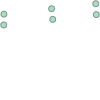

In [6]:
mp02_c

In [7]:
from shapely import affinity
from scipy.optimize import minimize

def mov(x,y,angle,geom):
    geom_r = affinity.rotate(geom,angle,origin=(0,0))
    geom_t = affinity.translate(geom_r,x,y)
    return geom_t

def calc_dist(geom1,geom2):
    dist = 0
    geom_list = zip(geom1,geom2)
    for item in geom_list:
        dist+=item[0].distance(item[1])
    return dist

def fun1(x0,geom1, geom2):
    x,y,angle = x0
    n_geom = mov(x,y,angle,geom2)
    return calc_dist(geom1,n_geom)

In [8]:
x0 = (0,0,0)

re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')

re

     fun: 0.003003306784588967
     jac: array([  -0.79069871,   -0.91463822,  225.65063539,    0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 248
     nit: 42
    njev: 42
  status: 0
 success: True
       x: array([  -7.69974863,  247.33610419,    0.99952728])

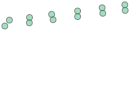

In [9]:
mp_moved = mov(*re.x,mp02)
mp_moved

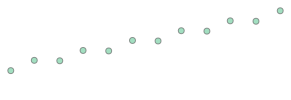

In [33]:
mp01

Считаем расстояния от стоянки 99002 до всех точек.  
До сдвижки, после сдвижки, значение сдвижки.

In [26]:
dist_do = [mp02[-1].distance(i) for i in mp02]
dist_po = [mp_moved[-1].distance(i) for i in mp_moved]
od = zip(dist_do,dist_po)
od = [[i[0],i[1],i[0]-i[1]] for i in od]
df_od = pd.DataFrame.from_records(od,columns=('Before','After','Diff'))
df_od

,Before,After,Diff
0,75.313632,75.313632,-1.136868e-12
1,49.955337,49.955337,-1.485034e-12
2,96.241950,96.241950,-1.747935e-12
3,119.435671,119.435671,-2.032152e-12
4,144.161730,144.161730,-7.958079e-13
5,96.753435,96.753435,-8.810730e-13
6,119.266772,119.266772,-1.861622e-12
7,144.996283,144.996283,-4.547474e-13
8,25.570046,25.570046,-4.405365e-13
9,25.691876,25.691876,-9.592327e-14


Расстояние между всеми точками:

In [27]:
all_l = []
for origin in mp02:
    nap = []
    for p in mp02:
        nap.append(origin.distance(p))
    all_l.append(nap)

all_2 = []
for origin in mp_moved:
    nap = []
    for p in mp_moved:
        nap.append(origin.distance(p))
    all_2.append(nap)

all_a = [list(zip(i[0],i[1])) for i in list(zip(all_l,all_2))]
all_a

[[(0.0, 0.0),
  (25.74630689341714, 25.746306893416882),
  (21.852457345799884, 21.852457345800506),
  (44.19520861654497, 44.19520861654585),
  (69.26795504199615, 69.26795504199576),
  (21.48007557016418, 21.480075570163887),
  (44.503928907120105, 44.50392890712084),
  (69.77711309999742, 69.77711309999673),
  (50.145573175804735, 50.14557317580539),
  (100.199883988955, 100.19988398895626),
  (125.82320662167245, 125.82320662167312),
  (75.31363161347349, 75.31363161347463)],
 [(25.74630689341714, 25.746306893416882),
  (0.0, 0.0),
  (46.28669485975471, 46.28669485975498),
  (69.57036460569935, 69.57036460569991),
  (94.2064019557592, 94.20640195575848),
  (46.96677935360224, 46.966779353601666),
  (69.31148210823409, 69.31148210823447),
  (95.09560141089516, 95.09560141089416),
  (25.58578744264036, 25.585787442641344),
  (75.24517116632781, 75.24517116632943),
  (100.5443121468837, 100.54431214688469),
  (49.95533711566719, 49.95533711566868)],
 [(21.852457345799884, 21.852457345

Таблица с координатам сдвинутого 99002:

In [34]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved.geoms))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df.sort_values(by='Num')



,Num,X,Y,Dist
10,604,-14403.697343,-341.609539,50.588975
9,605,-14427.593991,-352.114091,25.691876
11,606,-14453.281532,-351.642116,0.000000
8,607,-14476.664492,-361.989311,25.570046
1,608,-14502.246347,-361.540733,49.955337
0,609,-14525.824607,-371.881815,75.313632
2,610,-14547.639074,-370.593824,96.241950
5,610a,-14546.865103,-376.205146,96.753435
3,611,-14569.142428,-380.644396,119.435671
6,611a,-14570.208234,-375.151887,119.266772


Координаты 99001:

In [29]:
df01

,Num,X,Y
0,603,-14378.0490,-342.1180
1,602,-14354.7712,-331.8323
2,604,-14403.6978,-341.6095
3,605,-14427.5944,-352.1128
4,606,-14453.2814,-351.6420
5,607,-14476.6640,-361.9899
6,608,-14502.2464,-361.5407
7,609,-14525.8242,-371.8829
8,601,-14329.0375,-332.2493
9,599,-14279.7980,-322.3381


Оригинальные координаты 990002:

In [35]:
df02.sort_values(by='Num')

,Num,X,Y,Dist
10,604,-14404.7793,-325.0334,NaN
9,605,-14429.3495,-333.8482,NaN
11,606,-14454.9418,-331.5884,NaN
8,607,-14478.9886,-340.2820,NaN
1,608,-14504.4771,-338.0529,NaN
0,609,-14528.7183,-346.7268,NaN
2,610,-14550.3901,-343.9227,NaN
5,610a,-14550.0088,-349.5743,NaN
3,611,-14572.5412,-352.4513,NaN
6,611a,-14573.2219,-346.8979,NaN


In [31]:
df_stag = zip(df01.itertuples(),mov_df.itertuples())
list(df_stag)
staging = [[i[0][0],i[0][1],i[0][2],i[1][2],i[0][2]-i[1][2],i[0][3],i[1][3],i[0][3]-i[1][3],i[0][4],i[1][4],i[0][4]-i[1][4]] for i in list(df_stag)]

In [32]:
staged_df = pd.DataFrame.from_records(staging,columns=('Ind','Num','X01','X02_m','X_dist','Y01','Y02_m','Y_dist','Dist_01','Dist_02','Dist_dist'),index='Ind')
staged_df

,Num,X01,X02_m,X_dist,Y01,Y02_m,Y_dist,Dist_01,Dist_02,Dist_dist
Ind,,,,,,,,,,


g